# Phase 0 - Kaggle setup + copy/convert dataset (.webp -> .jpg)

In [1]:
import numpy as np
import pandas as pd    
import os
import random
import shutil
import logging
from pathlib import Path
from typing import Tuple
import tensorflow as tf
from PIL import Image, UnidentifiedImageError, ImageOps

# Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("Phase0")

print(f"TensorFlow version: {tf.__version__}")
logger.info(f"TensorFlow version: {tf.__version__}")

# Reproducibility
def configure_kaggle_reproducibility(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    logger.info(f"Reproducibility configured (seed={seed})")
    print(f"Reproducibility configured (seed={seed})")

# GPU setup
def setup_kaggle_gpu() -> None:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                logger.warning(f"Could not set memory growth: {e}")
        logger.info(f"GPU detected: {gpus[0].name}")
        print(f"GPU detected: {gpus[0].name}")
    else:
        logger.warning("No GPU found — running on CPU")
        print("No GPU found — running on CPU")

# Paths
SOURCE_PATH = Path("/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten")
DEST_PATH   = Path("/kaggle/working/cleaned_dataset")

# Utilities
def _unique_path(path: Path) -> Path:
    """Return a non-existing Path by appending _1, _2, ... if needed."""
    if not path.exists():
        return path
    i = 1
    stem, suffix = path.stem, path.suffix
    while True:
        candidate = path.with_name(f"{stem}_{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

def _save_jpg(img: Image.Image, out_path: Path, quality: int = 95) -> None:
    """Auto-orient, convert to RGB, and save as JPEG."""
    try:
        img = ImageOps.exif_transpose(img)
    except Exception:
        pass
    if img.mode not in ("RGB", "L"):
        img = img.convert("RGB")
    elif img.mode == "L":
        img = img.convert("RGB")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    img.save(out_path, format="JPEG", quality=quality, optimize=True, progressive=True)

def copy_and_convert_images(
    src_dir: Path, dest_dir: Path, jpg_quality: int = 95
) -> Tuple[int, int, int, int, int]:
    """
    Copies .jpg/.jpeg/.png as-is, converts .webp -> .jpg.
    Preserves folder structure. Returns counts: total, copied, converted, skipped, errors.
    """
    if not src_dir.exists():
        raise FileNotFoundError(f"Source path does not exist: {src_dir}")
    dest_dir.mkdir(parents=True, exist_ok=True)

    valid_exts = {".jpg", ".jpeg", ".png", ".webp"}
    total = copied = converted = skipped = errors = 0

    for root, _, files in os.walk(src_dir):
        for fname in files:
            total += 1
            src_path = Path(root) / fname
            ext = src_path.suffix.lower()
            if ext not in valid_exts:
                skipped += 1
                continue

            rel = src_path.relative_to(src_dir)

            try:
                if ext in {".jpg", ".jpeg", ".png"}:
                    dst_path = dest_dir / rel
                    dst_path.parent.mkdir(parents=True, exist_ok=True)
                    shutil.copy2(src_path, dst_path)
                    copied += 1

                elif ext == ".webp":
                    dst_path = dest_dir / rel.with_suffix(".jpg")
                    dst_path = _unique_path(dst_path)
                    with Image.open(src_path) as im:
                        if getattr(im, "is_animated", False):
                            im.seek(0)
                        _save_jpg(im, dst_path, quality=jpg_quality)
                    converted += 1

            except (UnidentifiedImageError, OSError, ValueError) as e:
                errors += 1
                logger.warning(f"Failed processing {src_path}: {e}")

    return total, copied, converted, skipped, errors

# Run Phase 0
print("Starting Phase 0: Kaggle environment setup and dataset preparation")
logger.info("Starting Phase 0")

configure_kaggle_reproducibility()
setup_kaggle_gpu()

total, copied, converted, skipped, errors = copy_and_convert_images(SOURCE_PATH, DEST_PATH, jpg_quality=95)

# Sanity check: ensure no .webp remains in cleaned dataset
leftover_webp = list(DEST_PATH.rglob("*.webp"))
if leftover_webp:
    logger.warning(f"Leftover .webp files found: {len(leftover_webp)}")
else:
    print("No .webp files remain in cleaned_dataset.")

print(f"Total files scanned: {total}")
print(f"Images copied (.jpg/.jpeg/.png): {copied}")
print(f".webp converted to .jpg: {converted}")
print(f"Errors: {errors}")
print(f"Cleaned dataset ready at: {DEST_PATH}")

print("Phase 0 completed successfully.")
logger.info("Phase 0 completed successfully.")

2025-09-07 17:23:00.752902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757265780.952167      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757265781.006123      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Starting Phase 0: Kaggle environment setup and dataset preparation
Reproducibility configured (seed=42)
GPU detected: /physical_device:GPU:0
No .webp files remain in cleaned_dataset.
Total files scanned: 29291
Images copied (.jpg/.jpeg/.png): 29277
.webp converted to .jpg: 14
Errors: 0
Cleaned dataset ready at: /kaggle/working/cleaned_dataset
Phase 0 completed successfully.


# Phase 1 - Dataset Metadata + Hyperparameters

In [3]:
import os
import pandas as pd        # For data manipulation and analysis
from pathlib import Path
from typing import Dict, Any
import tensorflow as tf

# Input path from Phase 0 output
DATASET_PATH = Path("/kaggle/working/cleaned_dataset/")

def load_dataset_metadata(dataset_path: Path) -> pd.DataFrame:
    """
    Walk the dataset folder and build a DataFrame with image paths and class labels.
    Includes only (.jpg/.jpeg/.png).
    """
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))

    df = pd.DataFrame(data, columns=["filepath", "label"])
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 finish successfully?")
    print(f"Total images: {len(df)}")
    print(f"Total classes: {df['label'].nunique()}")
    print("Per-class counts (sorted by name):")
    print(df['label'].value_counts().sort_index())
    return df

def create_class_mapping(df: pd.DataFrame) -> Dict[str, int]:
    """
    Map class names to integer IDs in a stable (sorted) order.
    """
    class_names = sorted(df['label'].unique())
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    print(f"Created class->index mapping for {len(class_names)} classes.")
    return class_to_idx

def define_kaggle_optimized_hyperparameters() -> Dict[str, Any]:
    """
    Hyperparameters tuned for Kaggle GPUs and cross-validation.
    """
    return {
        'dataset_path': str(DATASET_PATH),
        'output_path': "/kaggle/working/",
        'image_size': (224, 224, 3),
        'batch_size': 32,
        'epochs_stage1': 15,
        'epochs_stage2': 25,
        'learning_rate_stage1': 1e-3,
        'learning_rate_stage2': 1e-5,
        'dropout_rate': 0.3,
        'focal_loss_alpha': 0.25,
        'focal_loss_gamma': 2.0,
        'early_stopping_patience': 7,
        'reduce_lr_patience': 4,
        'test_split': 0.2,           # 20% for final test set
        'cv_folds': 5,               # 5-fold cross-validation
        'use_mixed_precision': True,
        'cache_preprocessed_data': True,
        'prefetch_buffer_size': tf.data.AUTOTUNE,
        'num_parallel_calls': tf.data.AUTOTUNE,
        'shuffle_buffer_size': 1000
    }

# Run Phase 1
print("Phase 1: Dataset Metadata Analysis")
df = load_dataset_metadata(DATASET_PATH)
class_to_idx = create_class_mapping(df)
hyperparams = define_kaggle_optimized_hyperparameters()
print("Phase 1 completed.")


Phase 1: Dataset Metadata Analysis
Total images: 29284
Total classes: 28
Per-class counts (sorted by name):
label
Apple__Healthy          2438
Apple__Rotten           2930
Banana__Healthy         1999
Banana__Rotten          2797
Bellpepper__Healthy      611
Bellpepper__Rotten       591
Carrot__Healthy          620
Carrot__Rotten           579
Cucumber__Healthy        608
Cucumber__Rotten         593
Grape__Healthy           200
Grape__Rotten            200
Guava__Healthy           200
Guava__Rotten            200
Jujube__Healthy          200
Jujube__Rotten           200
Mango__Healthy          1813
Mango__Rotten           2247
Orange__Healthy         2075
Orange__Rotten          2186
Pomegranate__Healthy     200
Pomegranate__Rotten      200
Potato__Healthy          615
Potato__Rotten           584
Strawberry__Healthy     1603
Strawberry__Rotten      1596
Tomato__Healthy          604
Tomato__Rotten           595
Name: count, dtype: int64
Created class->index mapping for 28 classes.
Pha

# Phase 2 - EDA (Essential Analysis Only)

Phase 2: Starting EDA...
Total images: 29284
Total classes: 28

Per-class counts:
label
Apple__Healthy          2438
Apple__Rotten           2930
Banana__Healthy         1999
Banana__Rotten          2797
Bellpepper__Healthy      611
Bellpepper__Rotten       591
Carrot__Healthy          620
Carrot__Rotten           579
Cucumber__Healthy        608
Cucumber__Rotten         593
Grape__Healthy           200
Grape__Rotten            200
Guava__Healthy           200
Guava__Rotten            200
Jujube__Healthy          200
Jujube__Rotten           200
Mango__Healthy          1813
Mango__Rotten           2247
Orange__Healthy         2075
Orange__Rotten          2186
Pomegranate__Healthy     200
Pomegranate__Rotten      200
Potato__Healthy          615
Potato__Rotten           584
Strawberry__Healthy     1603
Strawberry__Rotten      1596
Tomato__Healthy          604
Tomato__Rotten           595
Name: count, dtype: int64


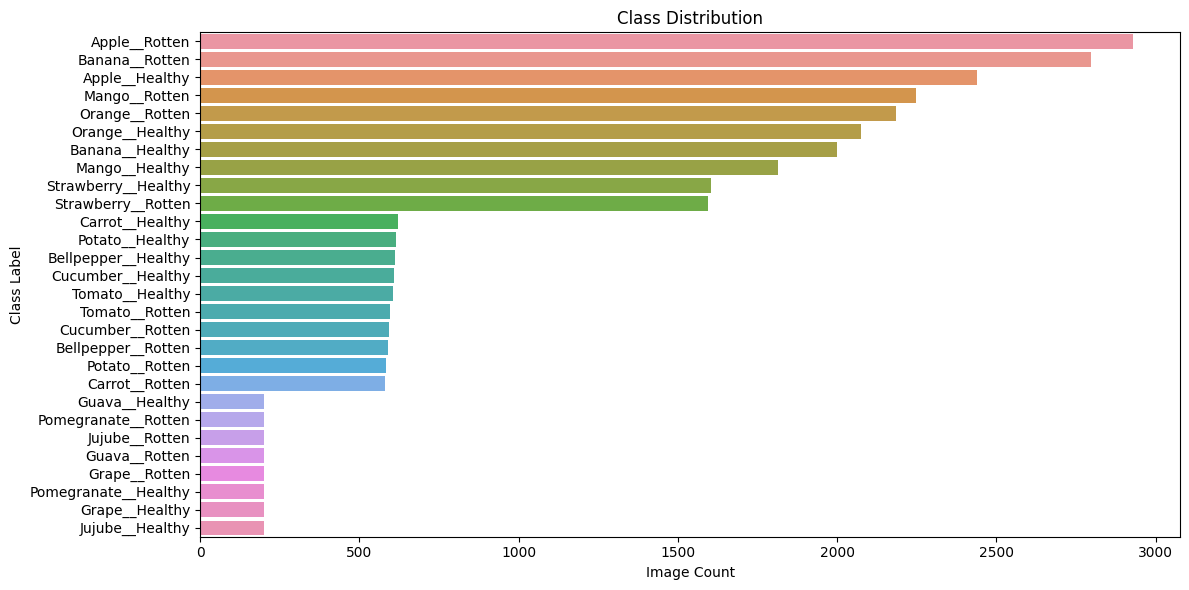

Phase 2 completed.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

DATASET_PATH = Path("/kaggle/working/cleaned_dataset/")

def get_image_dataframe(dataset_path: Path) -> pd.DataFrame:
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))
    df = pd.DataFrame(data, columns=["filepath", "label"])
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 run?")
    print(f"Total images: {len(df)}")
    print(f"Total classes: {df['label'].nunique()}")
    return df

def plot_class_distribution(df: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
    plt.title("Class Distribution")
    plt.xlabel("Image Count")
    plt.ylabel("Class Label")
    plt.tight_layout()
    plt.show()
    plt.close()

# Run Phase 2
print("Phase 2: Starting EDA...")
df_images = get_image_dataframe(DATASET_PATH)
print("\nPer-class counts:")
print(df_images['label'].value_counts().sort_index())

plot_class_distribution(df_images)
print("Phase 2 completed.")


# Phase 3 - Cross-Validation Splits (Enhanced from original)

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Paths
OUTPUT_SPLIT_DIR = Path("/kaggle/working/splits/")
OUTPUT_SPLIT_DIR.mkdir(parents=True, exist_ok=True)

# Split configuration from hyperparams
TEST_SIZE = hyperparams['test_split']
CV_FOLDS = hyperparams['cv_folds']
SEED = 42

def get_image_class_dataframe(dataset_path: Path) -> pd.DataFrame:
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))
    df = pd.DataFrame(data, columns=["filepath", "label"])
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 run?")
    # Stable order for reproducible splits
    df = df.sort_values("filepath").reset_index(drop=True)
    print(f"Found {len(df)} images in {df['label'].nunique()} classes")
    return df

def create_cv_splits_with_test(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Create: 1) Final test set (20%), 2) Cross-validation splits on remaining 80%
    """
    # Validate for stratification
    class_counts = df['label'].value_counts()
    min_samples = class_counts.min()
    
    if min_samples < CV_FOLDS + 1:
        raise ValueError(f"Insufficient samples for {CV_FOLDS}-fold CV. "
                        f"Minimum class has {min_samples} samples, need at least {CV_FOLDS + 1}")
    
    print(f"Creating {CV_FOLDS}-fold CV with {TEST_SIZE:.0%} test holdout...")
    
    # First split: separate test set
    df_train_val, df_test = train_test_split(
        df,
        test_size=TEST_SIZE,
        stratify=df['label'],
        random_state=SEED,
        shuffle=True
    )
    
    print(f"Final test set: {len(df_test)} images ({len(df_test)/len(df):.1%})")
    print(f"Train+Val set: {len(df_train_val)} images ({len(df_train_val)/len(df):.1%})")
    
    # Create K-fold splits on train_val data
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
    cv_splits = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df_train_val, df_train_val['label'])):
        train_data = df_train_val.iloc[train_idx].reset_index(drop=True)
        val_data = df_train_val.iloc[val_idx].reset_index(drop=True)
        
        cv_splits.append({
            'fold': fold_idx,
            'train': train_data,
            'val': val_data
        })
        
        print(f"Fold {fold_idx + 1}: Train={len(train_data)}, Val={len(val_data)}")
    
    return {
        'test_set': df_test.reset_index(drop=True),
        'cv_splits': cv_splits,
        'metadata': {
            'total_samples': len(df),
            'test_samples': len(df_test),
            'cv_samples': len(df_train_val),
            'num_folds': CV_FOLDS,
            'num_classes': df['label'].nunique(),
            'class_names': sorted(df['label'].unique())
        }
    }

# Run Phase 3
print("Phase 3: Starting cross-validation dataset split")
df_all = get_image_class_dataframe(DATASET_PATH)
splits_data = create_cv_splits_with_test(df_all)

# Save test set for final evaluation
test_csv_path = OUTPUT_SPLIT_DIR / "test_split.csv"
splits_data['test_set'].to_csv(test_csv_path, index=False)
print(f"Test set saved to: {test_csv_path}")

print("Phase 3 completed successfully.")

Phase 3: Starting cross-validation dataset split
Found 29284 images in 28 classes
Creating 5-fold CV with 20% test holdout...
Final test set: 5857 images (20.0%)
Train+Val set: 23427 images (80.0%)
Fold 1: Train=18741, Val=4686
Fold 2: Train=18741, Val=4686
Fold 3: Train=18742, Val=4685
Fold 4: Train=18742, Val=4685
Fold 5: Train=18742, Val=4685
Test set saved to: /kaggle/working/splits/test_split.csv
Phase 3 completed successfully.


# Phase 4 - tf.data pipeline (Cross-validation ready)

In [6]:
import json
import tensorflow as tf
from tensorflow.keras import layers

# Constants from hyperparams
BATCH_SIZE = hyperparams['batch_size']
IMAGE_SIZE = hyperparams['image_size'][:2]
AUTOTUNE = tf.data.AUTOTUNE

# Create stable class mapping from all data
def build_class_mapping(class_names):
    """Build stable class mapping with TensorFlow lookup table"""
    class_to_idx = {name: idx for idx, name in enumerate(sorted(class_names))}
    idx_to_class = [name for name, _ in sorted(class_to_idx.items(), key=lambda x: x[1])]
    
    # Create TensorFlow lookup table
    keys_tensor = tf.constant(list(class_to_idx.keys()))
    vals_tensor = tf.constant(list(class_to_idx.values()), dtype=tf.int64)
    table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
    lookup_table = tf.lookup.StaticHashTable(table_init, default_value=-1)
    
    return {
        'class_to_idx': class_to_idx,
        'idx_to_class': idx_to_class,
        'lookup_table': lookup_table,
        'num_classes': len(class_names)
    }

# Build class mapping
class_mapping = build_class_mapping(splits_data['metadata']['class_names'])
NUM_CLASSES = class_mapping['num_classes']

@tf.function
def decode_image(filename: tf.Tensor, label_str: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    img_raw = tf.io.read_file(filename)
    
    # Decode based on extension
    def decode_jpeg():
        return tf.image.decode_jpeg(img_raw, channels=3)
    
    def decode_png():
        return tf.image.decode_png(img_raw, channels=3)
    
    # Get extension
    ext = tf.strings.lower(tf.strings.split(filename, '.')[-1])
    img = tf.cond(
        tf.logical_or(tf.equal(ext, 'jpg'), tf.equal(ext, 'jpeg')),
        decode_jpeg,
        decode_png
    )
    
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMAGE_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.clip_by_value(img, 0, 255)
    img = tf.cast(img, tf.float32) / 255.0  # [0,1]

    label_id = class_mapping['lookup_table'].lookup(label_str)
    label_id = tf.where(label_id < 0, tf.zeros_like(label_id), label_id)
    one_hot = tf.one_hot(label_id, depth=NUM_CLASSES)
    return img, one_hot

@tf.function
def augment_image(image: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label

def build_dataset(df: pd.DataFrame, is_training: bool = True) -> tf.data.Dataset:
    """Build tf.data.Dataset from DataFrame"""
    filepaths = df['filepath'].values
    labels = df['label'].values
    
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    
    if is_training:
        ds = ds.shuffle(hyperparams['shuffle_buffer_size'], reshuffle_each_iteration=True)
    
    ds = ds.map(decode_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    ds = ds.prefetch(AUTOTUNE)
    return ds

def get_class_names():
    return class_mapping['idx_to_class']

print("Phase 4: tf.data pipeline ready for cross-validation")
print(f"Number of classes: {NUM_CLASSES}")
print("Phase 4 completed.")


Phase 4: tf.data pipeline ready for cross-validation
Number of classes: 28
Phase 4 completed.


I0000 00:00:1755887834.730107      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755887834.730894      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Phase 5 - MobileNetV2 model builder

In [7]:
# Import necessary components from TensorFlow/Keras
from tensorflow.keras import layers, models

def create_mobilenetv2_model(
    input_shape=(224, 224, 3),                     # Default image size: 224x224 pixels with 3 color channels (RGB)
    num_classes: int = 28,                         # Number of output classes for classification (e.g., 28 different categories)
    dropout_rate: float = 0.3,                     # Dropout probability to prevent overfitting (30% of neurons randomly turned off)
    trainable_backbone: bool = True,               # Whether to allow the pre-trained MobileNetV2 weights to be updated
    unfreeze_last_n: int = None,                   # Option to only train the last N layers of the backbone
    freeze_batch_norm: bool = True                 # Whether to keep BatchNorm layers frozen (recommended for fine-tuning)
) -> tf.keras.Model:
    """
    MobileNetV2 classifier with fine-tuning controls.
    """
    inputs = layers.Input(shape=input_shape, name="input_image") #Define the input layer
    x = layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input,
                      name="mbv2_preproc")(inputs)               # Preprocessing layer

     #  Load the pre-trained MobileNetV2 backbone
    base = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,                                 # Same input shape as our model
        include_top=False,                                       # Remove the final classification layers 
        weights="imagenet",                                      # Use weights pre-trained on ImageNet dataset
    )
    base._name = "mobilenetv2_base"                              # Give the base model a clear name for debugging/visualization
    base.trainable = trainable_backbone                          # Set whether the backbone layers can be trained

    # Fine-tuning configuration 
    if trainable_backbone and unfreeze_last_n is not None:
        # freeze all, then unfreeze the last N
        for layer in base.layers:                                # First, freeze ALL layers in the backbone
            layer.trainable = False
        for layer in base.layers[-unfreeze_last_n:]:             # Then, unfreeze only the LAST N layers for fine-tuning
            layer.trainable = True

        if freeze_batch_norm:                                    # BatchNorm layers special handling
            for layer in base.layers:
                if isinstance(layer, layers.BatchNormalization):
                    layer.trainable = False

    x = base(x)                                                  # Pass preprocessed input through the backbone
    x = layers.GlobalAveragePooling2D(name="gap")(x)             # Add custom classification head
    x = layers.Dropout(dropout_rate, name="dropout")(x)          # Dropout layer for regularization - randomly sets 30% of inputs to 0 during training
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)   # Final classification layer: Dense layer with softmax activation

    model = models.Model(inputs, outputs, name="mobilenetv2_finetune")                 # Create the complete model
    return model   # Return the constructed model

print("Phase 5: MobileNetV2 model builder ready")
print("Phase 5 completed.")

Phase 5: MobileNetV2 model builder ready
Phase 5 completed.


# phase 6 - Cross-Validation Training

In [8]:
# Import necessary modules from TensorFlow/Keras
from tensorflow.keras import callbacks
from tensorflow.keras.losses import CategoricalCrossentropy

# Enable mixed precision if configured
if hyperparams.get('use_mixed_precision', True):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')  # Set global policy to mixed precision
    print("Mixed precision enabled (float16).")                  # Confirmation message

# Pull hyperparams
EPOCHS1 = hyperparams['epochs_stage1']      # Number of epochs for stage 1 (frozen backbone)
EPOCHS2 = hyperparams['epochs_stage2']      # Number of epochs for stage 2 (fine-tuning)
LR1 = hyperparams['learning_rate_stage1']   # Learning rate for stage 1 (usually higher)
LR2 = hyperparams['learning_rate_stage2']   # Learning rate for stage 2 (usually lower for fine-tuning)
DROPOUT = hyperparams['dropout_rate']       # Dropout rate to prevent overfitting

# Output paths
CKPT_DIR = Path("/kaggle/working/checkpoints/")   # Directory to save model checkpoints
LOG_DIR = Path("/kaggle/working/logs/")           # Directory to save training logs
MODEL_DIR = Path("/kaggle/working/models/")       # Directory to save final models
for p in (CKPT_DIR, LOG_DIR, MODEL_DIR):          # Create all directories if they don't exist
    p.mkdir(parents=True, exist_ok=True)          # Create the fold-specific directory

def make_callbacks(fold_idx: int, stage: str):
    """Create callbacks for training"""
    fold_ckpt_dir = CKPT_DIR / f"fold_{fold_idx}"    # Create a separate checkpoint directory for each fold
    fold_ckpt_dir.mkdir(parents=True, exist_ok=True)
    
    return [                                                  # Return a list of three important callbacks
        callbacks.EarlyStopping(                              # Early stopping
            monitor="val_accuracy",                           # Metric to monitor
            patience=hyperparams['early_stopping_patience'],  # Number of epochs to wait before stopping
            mode="max",                                       # We want to maximize accuracy
            restore_best_weights=True                         # Load the best weights when stopping
        ),
         # Reduce learning rate when validation accuracy plateaus
        callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",                        # Metric to monitor
            factor=0.5,                                    # Multiply learning rate by this factor when reducing
            patience=hyperparams['reduce_lr_patience'],    # Epochs to wait before reducing
            mode="max",                                    # We want to maximize accuracy
            verbose=1,                                     # Print message when LR is reduced
            min_lr=1e-6                                    # Minimum learning rate threshold
        ),
        # Save the best model weights during training
        callbacks.ModelCheckpoint(
            str(fold_ckpt_dir / f"best_{stage}.h5"),  # File path to save the model
            monitor="val_accuracy",                   # Metric to monitor for "best" model
            save_best_only=True,                      # Only save when we achieve a new best score
            save_weights_only=False,                  # Save the entire model, not just weights
            mode="max"                                # We want to maximize accuracy
        )
    ]

def train_single_fold(fold_data, fold_idx):
    """Train a single fold with two-stage approach"""
    # Print a nice header to show which fold we're training
    print(f"\n{'='*60}")
    print(f"Training Fold {fold_idx + 1}/{len(splits_data['cv_splits'])}")
    print(f"{'='*60}")
    
    # Create datasets from the fold data
    train_ds = build_dataset(fold_data['train'], is_training=True)
    val_ds = build_dataset(fold_data['val'], is_training=False)  # No augmentation for validation
    
    # Create the MobileNetV2 model for this fold
    model = create_mobilenetv2_model(
        input_shape=hyperparams['image_size'],  # Input image dimensions
        num_classes=NUM_CLASSES,                # Number of output classes
        dropout_rate=DROPOUT,                   # Dropout rate for regularization
        trainable_backbone=False,               # Stage 1: keep backbone frozen
        freeze_batch_norm=True                  # Keep batch normalization layers frozen
    )
    
    # STAGE 1: Train with frozen backbone
    # This allows the classifier head to learn while keeping pre-trained features stable
    print("Stage 1: Training with frozen backbone...")
    
    # Create optimizer for stage 1 (typically uses higher learning rate)
    optimizer_1 = tf.keras.optimizers.Adam(learning_rate=LR1)
    
    # Compile the model with loss function and metrics
    model.compile(
        optimizer=optimizer_1,
        loss=CategoricalCrossentropy(label_smoothing=0.1),  # Label smoothing helps with overfitting
        metrics=["accuracy"]                                # Track accuracy during training
    )
    
    # Train the model for stage 1
    history_1 = model.fit(
        train_ds,                                          # Training dataset
        validation_data=val_ds,                            # Validation dataset
        epochs=EPOCHS1,                                    # Number of epochs for stage 1
        callbacks=make_callbacks(fold_idx, "stage1"),      # Callbacks for this stage
        verbose=1                                          # Print training progress
    )
    
    # Stage 2: fine-tune
    print("Stage 2: Fine-tuning with unfrozen layers...")
    try:                                             # Try to selectively unfreeze layers 
        base = model.get_layer("mobilenetv2_base")   # Get the base MobileNetV2 layer
        for l in base.layers:                        # First, freeze all layers
            l.trainable = False
        for l in base.layers[-50:]:                  # Unfreeze last 50 layers
            l.trainable = True
        for l in base.layers:                        # Keep all BatchNormalization layers frozen
            if isinstance(l, tf.keras.layers.BatchNormalization):
                l.trainable = False
        print("Unfroze last 50 layers (BatchNorm kept frozen)")
    except:                                          # Fallback: if the above fails, just unfreeze everything
        print("Fallback: unfroze entire model")
        for l in model.layers:
            l.trainable = True
    
    optimizer_2 = tf.keras.optimizers.Adam(learning_rate=LR2)   # Create new optimizer for stage 2 
    model.compile(                                              # Recompile the model with the new optimizer
        optimizer=optimizer_2,
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )
    
    # Train the model for stage 2 (fine-tuning)
    history_2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS2,                                # Number of epochs for stage 2
        callbacks=make_callbacks(fold_idx, "stage2"),  # Callbacks for this stage
        verbose=1
    )
    
    #  Evaluate the final model on validation data
    val_metrics = model.evaluate(val_ds, verbose=0)     # verbose=0 for quiet evaluation
    val_accuracy = val_metrics[1]                       # Extract accuracy 
    
    # Print the final results for this fold
    print(f"Fold {fold_idx + 1} Final Validation Accuracy: {val_accuracy:.4f}")
    
    # Return all important information about this fold's training
    return {
        'fold': fold_idx,  # Fold index
        'val_accuracy': val_accuracy,  # Final validation accuracy
        'val_loss': val_metrics[0],    # Final validation loss
        'model': model,                # Trained model
        'history': {                   # Training history from both stages
            'stage1': history_1.history,
            'stage2': history_2.history
        }
    }

# MAIN CROSS-VALIDATION LOOP
print("Starting Cross-Validation Training...")

# Initialize lists to store results
cv_results = []  # Store results from each fold
all_models = []  # Store all trained models

# Loop through each fold in the cross-validation splits
for fold_idx, fold_data in enumerate(splits_data['cv_splits']):
    # Train this fold and get results
    fold_result = train_single_fold(fold_data, fold_idx)
    # Store the results
    cv_results.append(fold_result)
    all_models.append(fold_result['model'])
    
    # Clean up memory
    tf.keras.backend.clear_session()

# Calculate CV statistics
fold_accuracies = [result['val_accuracy'] for result in cv_results]
cv_mean = np.mean(fold_accuracies)       # Average accuracy
cv_std = np.std(fold_accuracies)         # Standard deviation 

# Print comprehensive summary of cross-validation results
print(f"\n{'='*60}")
print(f"Cross-Validation Results Summary")
print(f"{'='*60}")
print(f"Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Individual folds: {[f'{acc:.4f}' for acc in fold_accuracies]}")
print(f"Best fold: {max(fold_accuracies):.4f}")
print(f"Worst fold: {min(fold_accuracies):.4f}")

print("Cross-Validation Training completed.")



Mixed precision enabled (float16).
Starting Cross-Validation Training...

Training Fold 1/5
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Stage 1: Training with frozen backbone...
Epoch 1/15


I0000 00:00:1755887857.664455     101 service.cc:148] XLA service 0x7918e80424b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755887857.665699     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755887857.665721     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755887858.823059     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


      4/Unknown 15s 21ms/step - accuracy: 0.0254 - loss: 3.9433   

I0000 00:00:1755887865.407398     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    585/Unknown 82s 114ms/step - accuracy: 0.0947 - loss: 3.2213

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


585/585 ━━━━━━━━━━━━━━━━━━━━ 98s 143ms/step - accuracy: 0.0947 - loss: 3.2211 - val_accuracy: 0.1396 - val_loss: 2.9314 - learning_rate: 0.0010
Epoch 2/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step - accuracy: 0.1500 - loss: 2.9657 - val_accuracy: 0.1626 - val_loss: 2.8458 - learning_rate: 0.0010
Epoch 3/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step - accuracy: 0.1716 - loss: 2.8832 - val_accuracy: 0.1929 - val_loss: 2.7808 - learning_rate: 0.0010
Epoch 4/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 71s 121ms/step - accuracy: 0.1825 - loss: 2.8436 - val_accuracy: 0.2185 - val_loss: 2.7738 - learning_rate: 0.0010
Epoch 5/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 69s 117ms/step - accuracy: 0.1985 - loss: 2.8140 - val_accuracy: 0.2049 - val_loss: 2.7641 - learning_rate: 0.0010
Epoch 6/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 74s 126ms/step - accuracy: 0.1930 - loss: 2.8012 - val_accuracy: 0.2025 - val_loss: 2.7118 - learning_rate: 0.0010
Epoch 7/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 67s 114ms/step - accuracy: 0.2030 - loss:

# Phase 7 - Final Model Selection and Test Evaluation

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from pathlib import Path
import pandas as pd
import numpy as np


RESULTS_DIR = Path("/kaggle/working/results/")  
MODEL_DIR = Path("models")     

# Select best model from CV
best_fold_idx = np.argmax(fold_accuracies)
best_model = cv_results[best_fold_idx]['model']
print(f"Selected best model from fold {best_fold_idx + 1} (accuracy: {fold_accuracies[best_fold_idx]:.4f})")

# Save best model
final_model_path = MODEL_DIR / "best_mobilenetv2_final.h5"
best_model.save(final_model_path)
print(f"Best model saved to: {final_model_path}")

# Evaluate on test set
print(f"\n{'='*60}")
print(f"Final Test Set Evaluation")
print(f"{'='*60}")

test_ds = build_dataset(splits_data['test_set'], is_training=False)

# Collect predictions
y_true_idx = []
y_pred_probs = []
print("Collecting predictions on test set...")

for batch_imgs, batch_labels in test_ds:
    y_true_idx.extend(tf.argmax(batch_labels, axis=-1).numpy())
    preds = best_model.predict(batch_imgs, verbose=0)
    y_pred_probs.extend(preds)

y_true_idx = np.array(y_true_idx)
y_pred_probs = np.array(y_pred_probs)
y_pred_idx = np.argmax(y_pred_probs, axis=-1)

# Calculate metrics
test_accuracy = accuracy_score(y_true_idx, y_pred_idx)

# Top-k accuracies
def top_k_accuracy(y_true, y_prob, k):
    top_k_preds = np.argsort(-y_prob, axis=1)[:, :k]
    return np.mean([y_true[i] in top_k_preds[i] for i in range(len(y_true))])

top3_accuracy = top_k_accuracy(y_true_idx, y_pred_probs, 3)
top5_accuracy = top_k_accuracy(y_true_idx, y_pred_probs, 5)

# Classification report
class_names = get_class_names()
clf_report = classification_report(
    y_true_idx, y_pred_idx, 
    target_names=class_names, 
    output_dict=True, 
    zero_division=0
)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_idx, y_pred_idx)

print(f"Test Accuracy (Top-1): {test_accuracy:.4f}")
print(f"Test Accuracy (Top-3): {top3_accuracy:.4f}")
print(f"Test Accuracy (Top-5): {top5_accuracy:.4f}")

# Calculate precision, recall, f1-score for each class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average=None, zero_division=0
)

# Calculate macro and weighted averages 
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='macro', zero_division=0
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='weighted', zero_division=0
)

# Create comprehensive metrics table
metrics_table = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Add summary rows
summary_rows = pd.DataFrame({
    'Class': ['Macro Avg', 'Weighted Avg'],
    'Precision': [precision_macro, precision_weighted],
    'Recall': [recall_macro, recall_weighted],
    'F1-Score': [f1_macro, f1_weighted],
    'Support': [np.sum(support), np.sum(support)]
})

metrics_table = pd.concat([metrics_table, summary_rows], ignore_index=True)

# Display table
print(f"\nPrecision, Recall, F1-Score Table:")
print("=" * 60)
print(metrics_table.round(4).to_string(index=False))

# Save table 
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
metrics_table.to_csv(RESULTS_DIR / "precision_recall_f1_table.csv", index=False)
print(f"\nMetrics table saved to: {RESULTS_DIR / 'precision_recall_f1_table.csv'}")

print("Phase 6 completed.")

Selected best model from fold 5 (accuracy: 0.9671)
Best model saved to: models/best_mobilenetv2_final.h5

Final Test Set Evaluation
Test Accuracy (Top-1): 0.9584
Test Accuracy (Top-3): 0.9921
Test Accuracy (Top-5): 0.9964

Precision, Recall, F1-Score Table:
               Class  Precision  Recall  F1-Score  Support
      Apple__Healthy     0.9835  0.9896    0.9866      483
       Apple__Rotten     0.9576  0.9691    0.9633      582
     Banana__Healthy     0.9749  0.9923    0.9836      392
      Banana__Rotten     0.9822  0.9964    0.9893      555
 Bellpepper__Healthy     0.8779  0.9583    0.9163      120
  Bellpepper__Rotten     0.8119  0.7069    0.7558      116
     Carrot__Healthy     0.9412  0.9256    0.9333      121
      Carrot__Rotten     0.8783  0.8783    0.8783      115
   Cucumber__Healthy     0.9134  0.9508    0.9317      122
    Cucumber__Rotten     0.8760  0.8983    0.8870      118
      Grape__Healthy     1.0000  0.9750    0.9873       40
       Grape__Rotten     0.9756  1

# Phase 8 - Comprehensive Evaluation and Visualization

Creating visualizations...


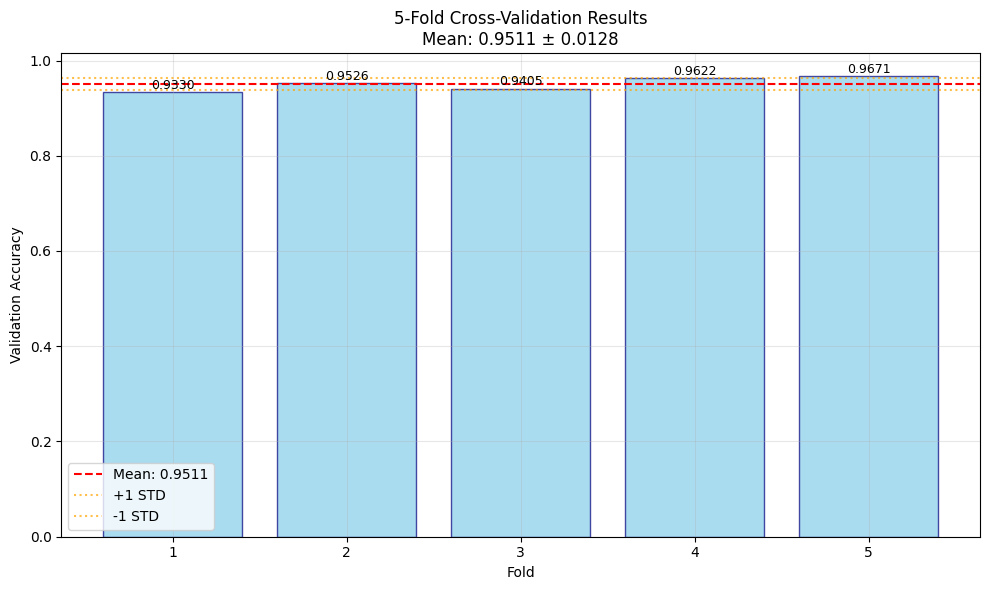

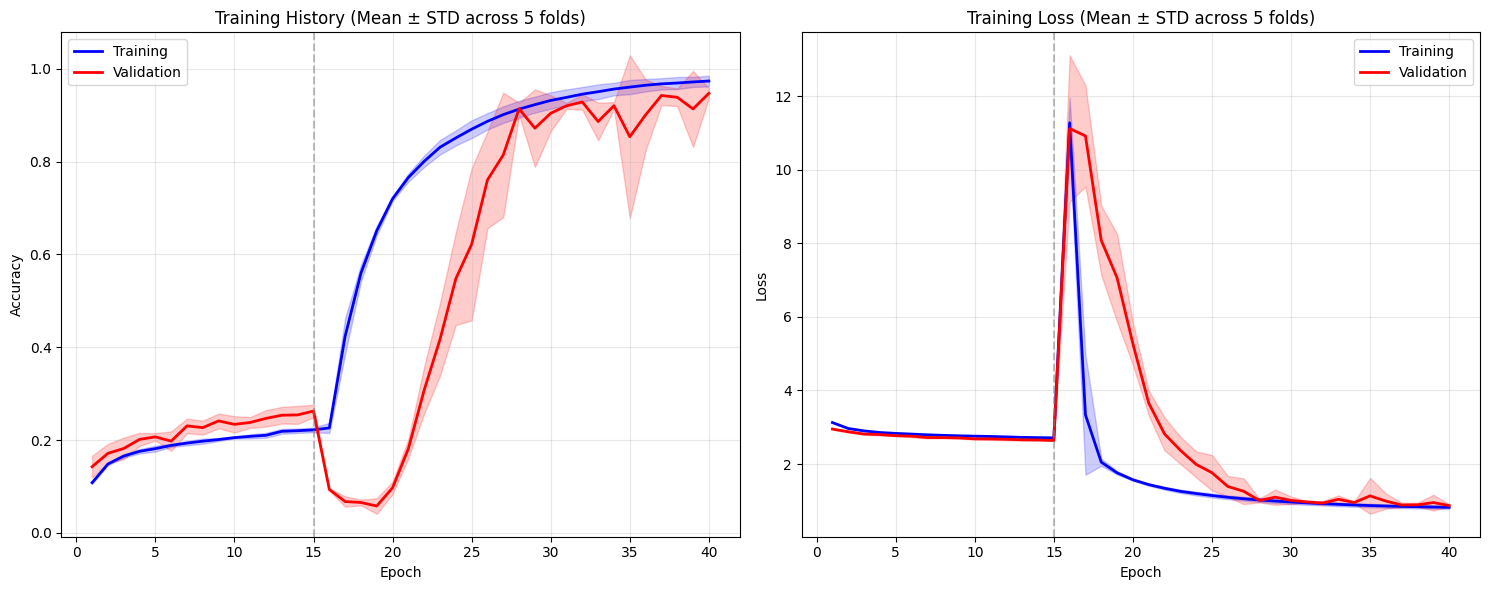

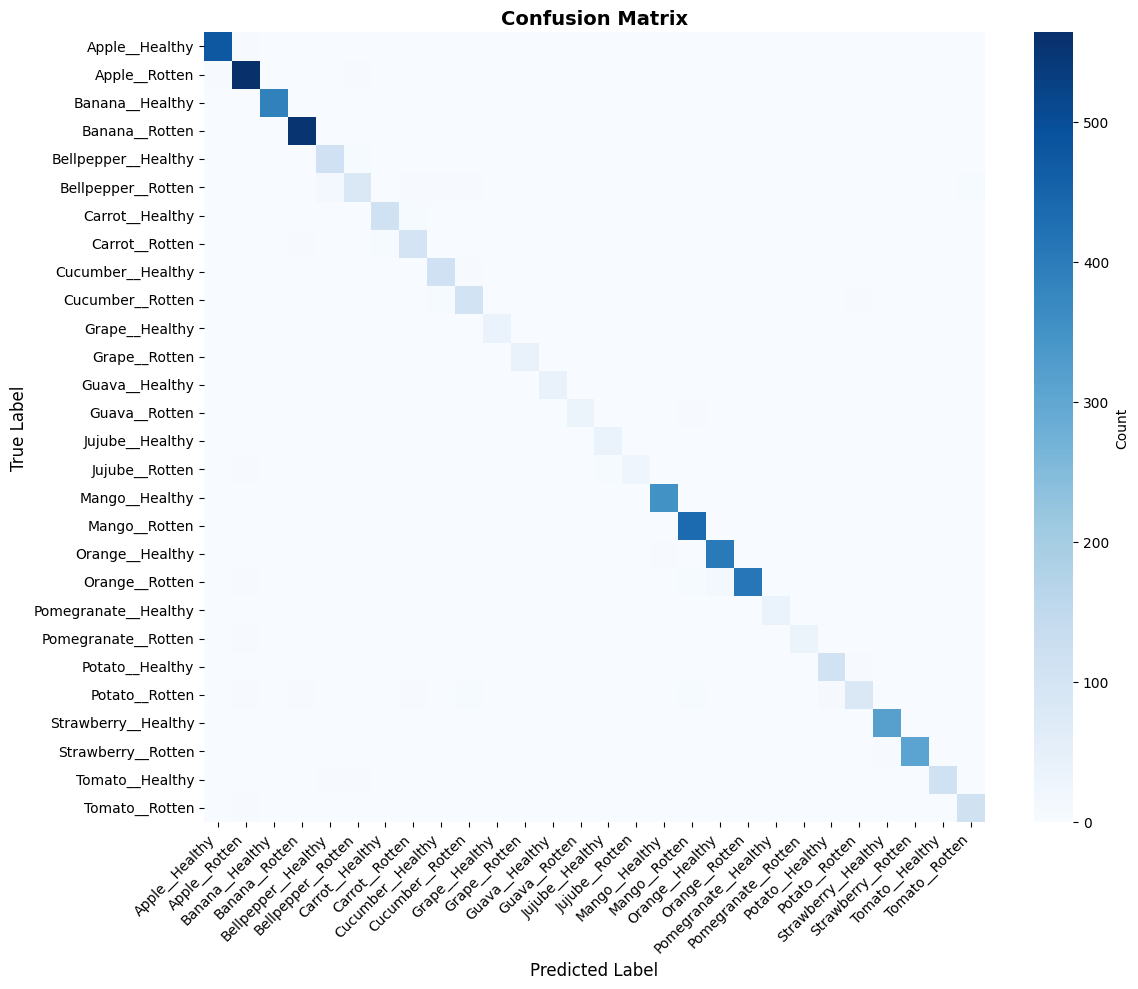

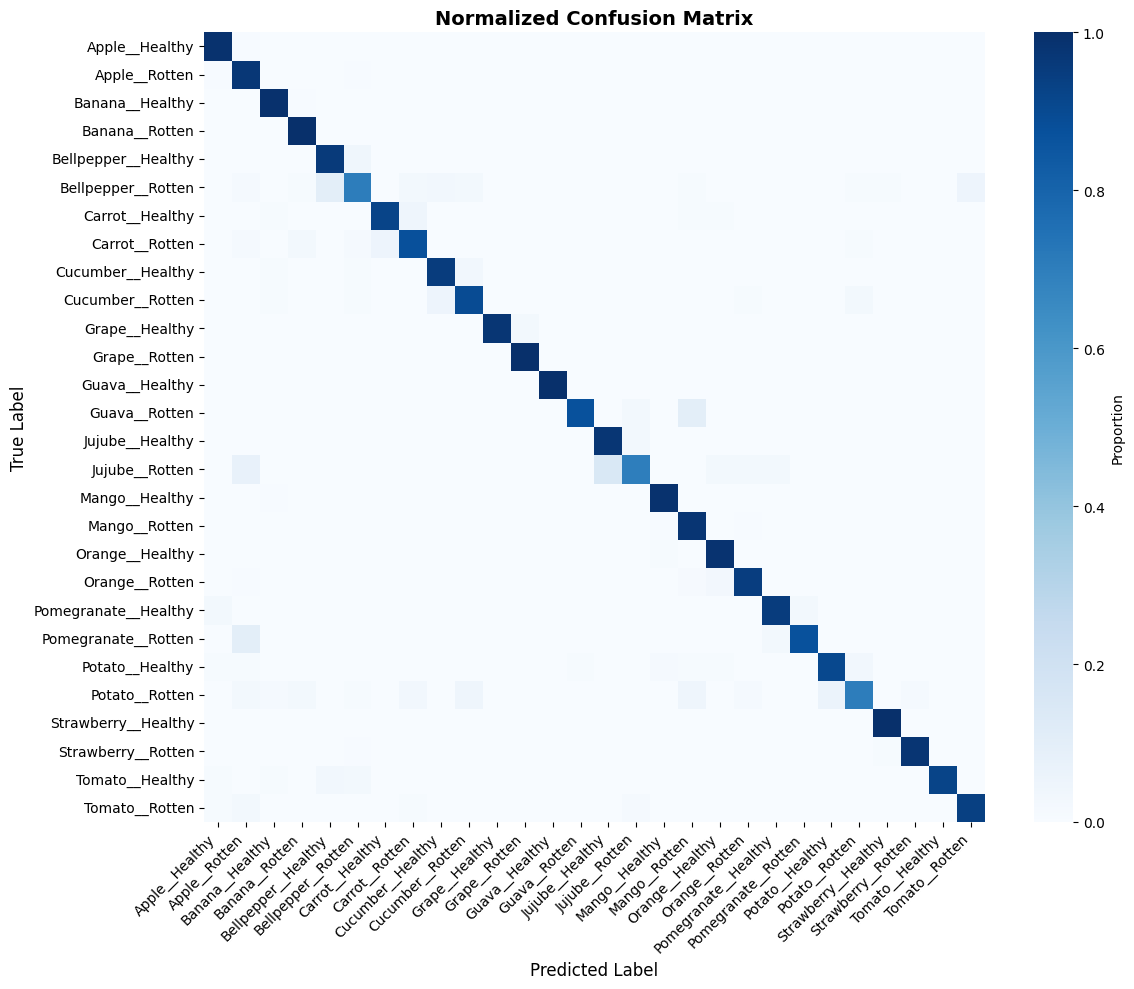

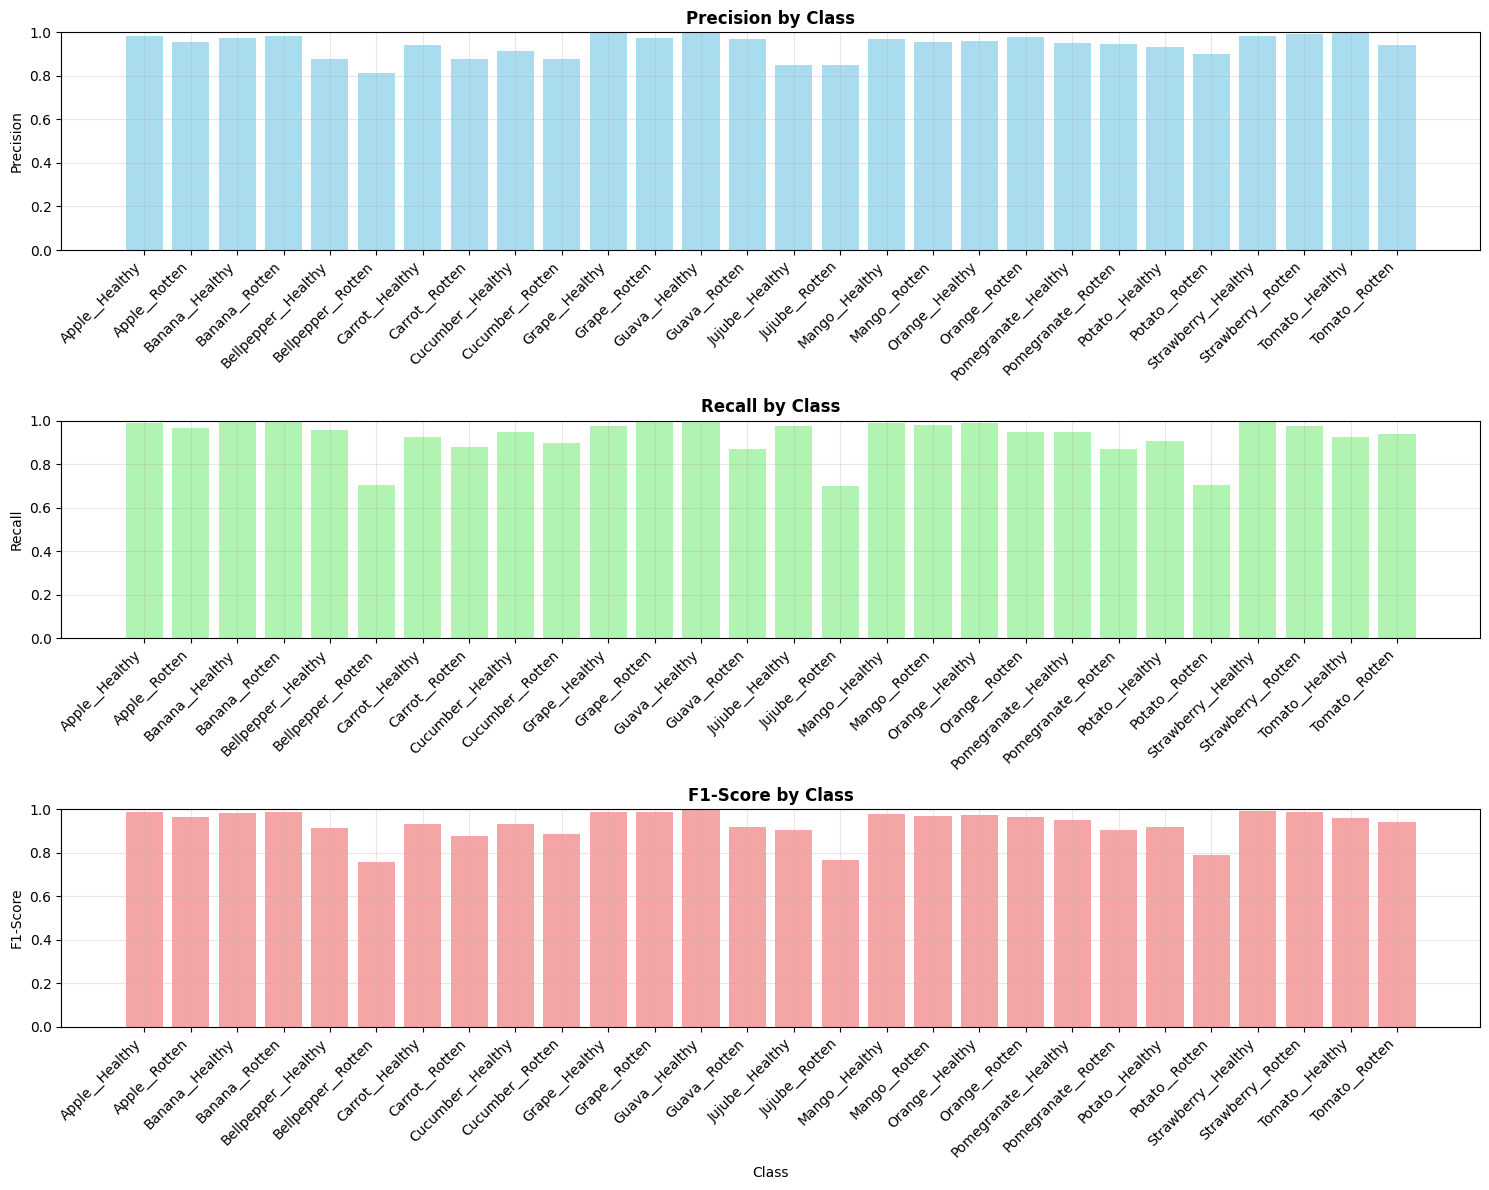

Creating additional analysis plots...


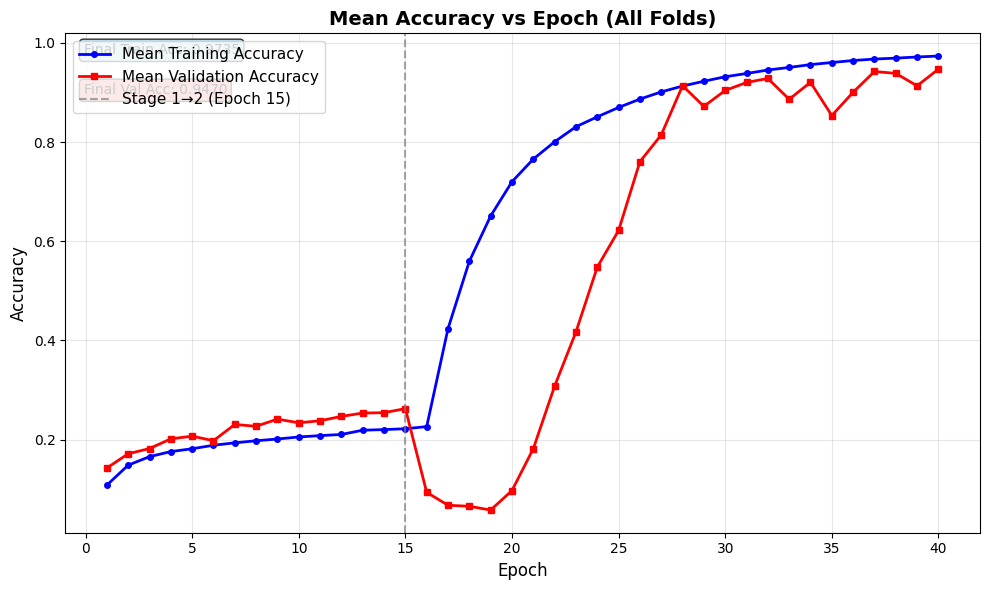

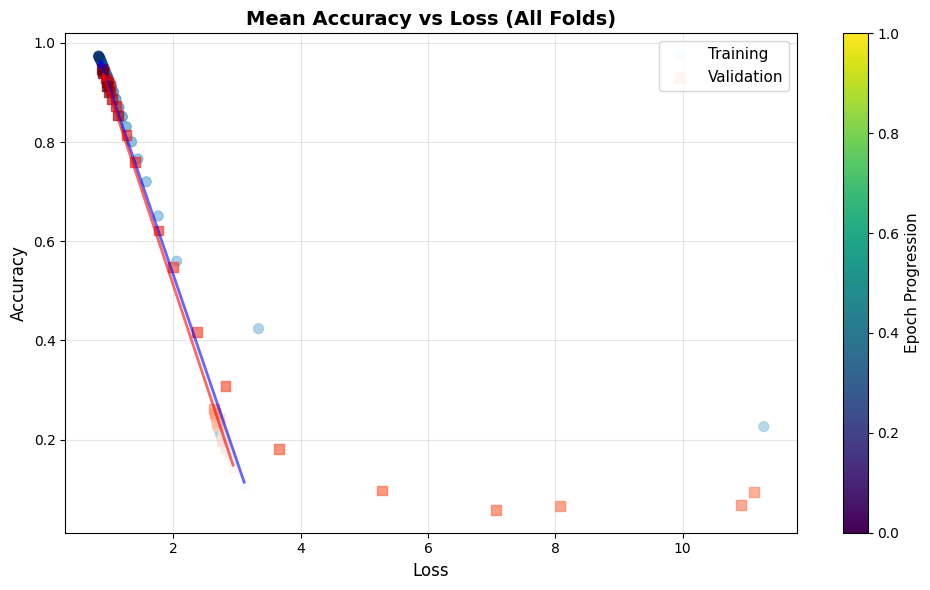

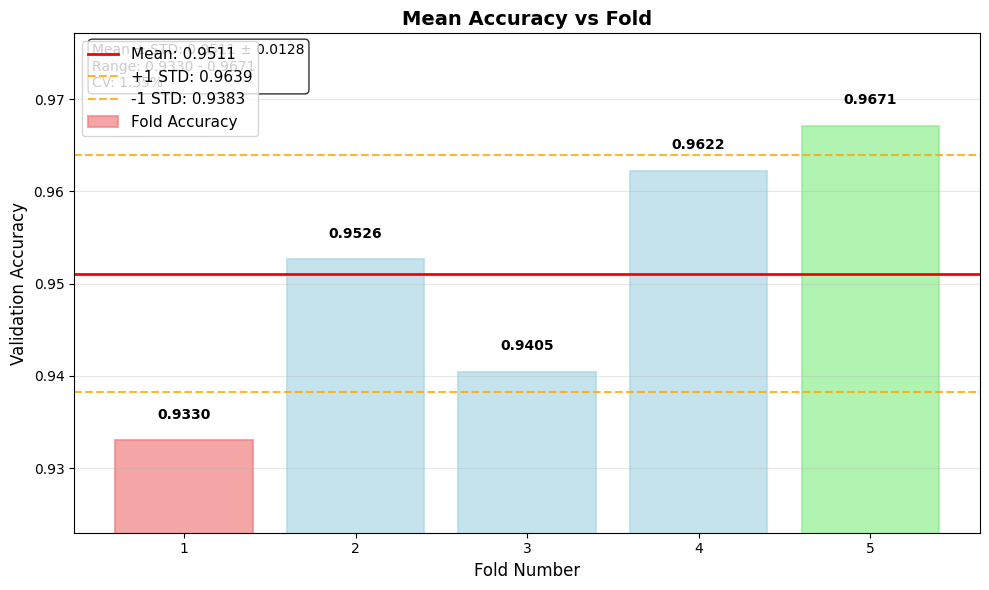

Phase 7 completed.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create results directory
RESULTS_DIR = Path("/kaggle/working/results/")
PLOTS_DIR = RESULTS_DIR / "plots"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Plot Cross-Validation Results
def plot_cv_results():
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(1, len(fold_accuracies) + 1), fold_accuracies, 
                  alpha=0.7, color='skyblue', edgecolor='navy')
    plt.axhline(y=cv_mean, color='red', linestyle='--', 
               label=f"Mean: {cv_mean:.4f}")
    plt.axhline(y=cv_mean + cv_std, color='orange', linestyle=':', alpha=0.7, label=f"+1 STD")
    plt.axhline(y=cv_mean - cv_std, color='orange', linestyle=':', alpha=0.7, label=f"-1 STD")
    
    plt.xlabel('Fold')
    plt.ylabel('Validation Accuracy')
    plt.title(f'{len(fold_accuracies)}-Fold Cross-Validation Results\n'
             f'Mean: {cv_mean:.4f} ± {cv_std:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, fold_accuracies)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{acc:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "cv_fold_accuracies.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot Training History (Combined across folds)
def plot_training_histories():
    # Aggregate training histories
    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []
    
    max_epochs = 0
    
    for result in cv_results:
        hist = result['history']
        stage1 = hist['stage1']
        stage2 = hist['stage2']
        
        combined_train_acc = stage1.get('accuracy', []) + stage2.get('accuracy', [])
        combined_val_acc = stage1.get('val_accuracy', []) + stage2.get('val_accuracy', [])
        combined_train_loss = stage1.get('loss', []) + stage2.get('loss', [])
        combined_val_loss = stage1.get('val_loss', []) + stage2.get('val_loss', [])
        
        all_train_acc.append(combined_train_acc)
        all_val_acc.append(combined_val_acc)
        all_train_loss.append(combined_train_loss)
        all_val_loss.append(combined_val_loss)
        
        max_epochs = max(max_epochs, len(combined_train_acc))
    
    # Pad sequences and calculate mean/std
    def pad_sequence(seq, target_length):
        if len(seq) < target_length:
            return seq + [seq[-1]] * (target_length - len(seq))
        return seq[:target_length]
    
    for i in range(len(all_train_acc)):
        all_train_acc[i] = pad_sequence(all_train_acc[i], max_epochs)
        all_val_acc[i] = pad_sequence(all_val_acc[i], max_epochs)
        all_train_loss[i] = pad_sequence(all_train_loss[i], max_epochs)
        all_val_loss[i] = pad_sequence(all_val_loss[i], max_epochs)
    
    all_train_acc = np.array(all_train_acc)
    all_val_acc = np.array(all_val_acc)
    all_train_loss = np.array(all_train_loss)
    all_val_loss = np.array(all_val_loss)
    
    mean_train_acc = np.mean(all_train_acc, axis=0)
    std_train_acc = np.std(all_train_acc, axis=0)
    mean_val_acc = np.mean(all_val_acc, axis=0)
    std_val_acc = np.std(all_val_acc, axis=0)
    
    mean_train_loss = np.mean(all_train_loss, axis=0)
    std_train_loss = np.std(all_train_loss, axis=0)
    mean_val_loss = np.mean(all_val_loss, axis=0)
    std_val_loss = np.std(all_val_loss, axis=0)
    
    epochs = range(1, max_epochs + 1)
    
    plt.figure(figsize=(15, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mean_train_acc, 'b-', label='Training', linewidth=2)
    plt.fill_between(epochs, 
                    mean_train_acc - std_train_acc, 
                    mean_train_acc + std_train_acc, 
                    alpha=0.2, color='blue')
    
    plt.plot(epochs, mean_val_acc, 'r-', label='Validation', linewidth=2)
    plt.fill_between(epochs, 
                    mean_val_acc - std_val_acc, 
                    mean_val_acc + std_val_acc, 
                    alpha=0.2, color='red')
    
    plt.title(f'Training History (Mean ± STD across {len(cv_results)} folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add stage separator
    stage1_epochs = EPOCHS1
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.5)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mean_train_loss, 'b-', label='Training', linewidth=2)
    plt.fill_between(epochs, 
                    mean_train_loss - std_train_loss, 
                    mean_train_loss + std_train_loss, 
                    alpha=0.2, color='blue')
    
    plt.plot(epochs, mean_val_loss, 'r-', label='Validation', linewidth=2)
    plt.fill_between(epochs, 
                    mean_val_loss - std_val_loss, 
                    mean_val_loss + std_val_loss, 
                    alpha=0.2, color='red')
    
    plt.title(f'Training Loss (Mean ± STD across {len(cv_results)} folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "cv_training_history.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot Confusion Matrix
def plot_confusion_matrix(normalize=False):
    if normalize:
        cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
        fmt = '.2f'
        filename = 'confusion_matrix_normalized.png'
    else:
        cm = conf_matrix
        title = 'Confusion Matrix'
        fmt = 'd'
        filename = 'confusion_matrix.png'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, 
               annot=False,  # Too many classes for text
               fmt=fmt,
               cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names,
               cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot Per-Class Metrics
def plot_per_class_metrics():
    # Extract per-class metrics
    precisions = []
    recalls = []
    f1_scores = []
    
    for class_name in class_names:
        if class_name in clf_report:
            precisions.append(clf_report[class_name]['precision'])
            recalls.append(clf_report[class_name]['recall'])
            f1_scores.append(clf_report[class_name]['f1-score'])
        else:
            precisions.append(0.0)
            recalls.append(0.0)
            f1_scores.append(0.0)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    x_pos = np.arange(len(class_names))
    
    # Precision
    axes[0].bar(x_pos, precisions, alpha=0.7, color='skyblue')
    axes[0].set_title('Precision by Class', fontweight='bold')
    axes[0].set_ylabel('Precision')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)
    
    # Recall
    axes[1].bar(x_pos, recalls, alpha=0.7, color='lightgreen')
    axes[1].set_title('Recall by Class', fontweight='bold')
    axes[1].set_ylabel('Recall')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
    
    # F1-Score
    axes[2].bar(x_pos, f1_scores, alpha=0.7, color='lightcoral')
    axes[2].set_title('F1-Score by Class', fontweight='bold')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_xlabel('Class')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3)
    
    # Set x-axis labels
    for ax in axes:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "per_class_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot Mean Accuracy vs Epoch (All Folds)
def plot_mean_accuracy_vs_epoch():
    """Plot mean accuracy across all folds vs epoch"""
    # Aggregate training histories (reuse logic from plot_training_histories)
    all_train_acc = []
    all_val_acc = []
    max_epochs = 0
    
    for result in cv_results:
        hist = result['history']
        stage1 = hist['stage1']
        stage2 = hist['stage2']
        
        combined_train_acc = stage1.get('accuracy', []) + stage2.get('accuracy', [])
        combined_val_acc = stage1.get('val_accuracy', []) + stage2.get('val_accuracy', [])
        
        all_train_acc.append(combined_train_acc)
        all_val_acc.append(combined_val_acc)
        max_epochs = max(max_epochs, len(combined_train_acc))
    
    # Pad sequences
    def pad_sequence(seq, target_length):
        if len(seq) < target_length:
            return seq + [seq[-1]] * (target_length - len(seq))
        return seq[:target_length]
    
    for i in range(len(all_train_acc)):
        all_train_acc[i] = pad_sequence(all_train_acc[i], max_epochs)
        all_val_acc[i] = pad_sequence(all_val_acc[i], max_epochs)
    
    all_train_acc = np.array(all_train_acc)
    all_val_acc = np.array(all_val_acc)
    
    mean_train_acc = np.mean(all_train_acc, axis=0)
    mean_val_acc = np.mean(all_val_acc, axis=0)
    
    epochs = range(1, max_epochs + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_train_acc, 'b-', label='Mean Training Accuracy', linewidth=2, marker='o', markersize=4)
    plt.plot(epochs, mean_val_acc, 'r-', label='Mean Validation Accuracy', linewidth=2, marker='s', markersize=4)
    
    plt.title('Mean Accuracy vs Epoch (All Folds)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add stage separator
    stage1_epochs = EPOCHS1
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.7, 
               label=f'Stage 1→2 (Epoch {stage1_epochs})')
    plt.legend(fontsize=11)
    
    # Add final accuracy values as text
    plt.text(0.02, 0.98, f'Final Train Acc: {mean_train_acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.text(0.02, 0.90, f'Final Val Acc: {mean_val_acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "mean_accuracy_vs_epoch.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot Mean Accuracy vs Loss (All Folds)
def plot_mean_accuracy_vs_loss():
    """Plot mean accuracy vs mean loss across all folds"""
    # Reuse aggregated data from previous function
    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []
    max_epochs = 0
    
    for result in cv_results:
        hist = result['history']
        stage1 = hist['stage1']
        stage2 = hist['stage2']
        
        combined_train_acc = stage1.get('accuracy', []) + stage2.get('accuracy', [])
        combined_val_acc = stage1.get('val_accuracy', []) + stage2.get('val_accuracy', [])
        combined_train_loss = stage1.get('loss', []) + stage2.get('loss', [])
        combined_val_loss = stage1.get('val_loss', []) + stage2.get('val_loss', [])
        
        all_train_acc.append(combined_train_acc)
        all_val_acc.append(combined_val_acc)
        all_train_loss.append(combined_train_loss)
        all_val_loss.append(combined_val_loss)
        max_epochs = max(max_epochs, len(combined_train_acc))
    
    # Pad sequences
    def pad_sequence(seq, target_length):
        if len(seq) < target_length:
            return seq + [seq[-1]] * (target_length - len(seq))
        return seq[:target_length]
    
    for i in range(len(all_train_acc)):
        all_train_acc[i] = pad_sequence(all_train_acc[i], max_epochs)
        all_val_acc[i] = pad_sequence(all_val_acc[i], max_epochs)
        all_train_loss[i] = pad_sequence(all_train_loss[i], max_epochs)
        all_val_loss[i] = pad_sequence(all_val_loss[i], max_epochs)
    
    all_train_acc = np.array(all_train_acc)
    all_val_acc = np.array(all_val_acc)
    all_train_loss = np.array(all_train_loss)
    all_val_loss = np.array(all_val_loss)
    
    mean_train_acc = np.mean(all_train_acc, axis=0)
    mean_val_acc = np.mean(all_val_acc, axis=0)
    mean_train_loss = np.mean(all_train_loss, axis=0)
    mean_val_loss = np.mean(all_val_loss, axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(mean_train_loss, mean_train_acc, c=range(len(mean_train_acc)), 
               cmap='Blues', s=50, alpha=0.7, label='Training', marker='o')
    plt.scatter(mean_val_loss, mean_val_acc, c=range(len(mean_val_acc)), 
               cmap='Reds', s=50, alpha=0.7, label='Validation', marker='s')
    
    # Add colorbar to show epoch progression
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gca())
    cbar.set_label('Epoch Progression', fontsize=11)
    
    plt.title('Mean Accuracy vs Loss (All Folds)', fontsize=14, fontweight='bold')
    plt.xlabel('Loss', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add arrows to show training progression
    if len(mean_train_acc) > 1:
        plt.annotate('', xy=(mean_train_loss[-1], mean_train_acc[-1]), 
                    xytext=(mean_train_loss[0], mean_train_acc[0]),
                    arrowprops=dict(arrowstyle='->', color='blue', alpha=0.6, lw=2))
        plt.annotate('', xy=(mean_val_loss[-1], mean_val_acc[-1]), 
                    xytext=(mean_val_loss[0], mean_val_acc[0]),
                    arrowprops=dict(arrowstyle='->', color='red', alpha=0.6, lw=2))
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "mean_accuracy_vs_loss.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot Mean Accuracy vs Fold
def plot_mean_accuracy_vs_fold():
    """Plot mean accuracy for each fold"""
    fold_numbers = range(1, len(fold_accuracies) + 1)
    
    plt.figure(figsize=(10, 6))
    
    # Bar plot with individual fold accuracies
    bars = plt.bar(fold_numbers, fold_accuracies, alpha=0.7, color='lightblue', 
                   edgecolor='navy', linewidth=1.5, label='Fold Accuracy')
    
    # Add mean line
    plt.axhline(y=cv_mean, color='red', linestyle='-', linewidth=2, 
               label=f'Mean: {cv_mean:.4f}')
    
    # Add std deviation lines
    plt.axhline(y=cv_mean + cv_std, color='orange', linestyle='--', alpha=0.8, 
               label=f'+1 STD: {cv_mean + cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='orange', linestyle='--', alpha=0.8, 
               label=f'-1 STD: {cv_mean - cv_std:.4f}')
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, fold_accuracies)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Color code bars based on performance relative to mean
        if acc > cv_mean + cv_std:
            bar.set_color('lightgreen')
        elif acc < cv_mean - cv_std:
            bar.set_color('lightcoral')
        else:
            bar.set_color('lightblue')
    
    plt.title('Mean Accuracy vs Fold', fontsize=14, fontweight='bold')
    plt.xlabel('Fold Number', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Set y-axis to show reasonable range
    y_min = min(fold_accuracies) - 0.01
    y_max = max(fold_accuracies) + 0.01
    plt.ylim(y_min, y_max)
    
    # Add statistics text box
    stats_text = f'Mean ± STD: {cv_mean:.4f} ± {cv_std:.4f}\n'
    stats_text += f'Range: {min(fold_accuracies):.4f} - {max(fold_accuracies):.4f}\n'
    stats_text += f'CV: {(cv_std/cv_mean)*100:.2f}%'
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=10)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "mean_accuracy_vs_fold.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


# Generate all plots
print("Creating visualizations...")
plot_cv_results()
plot_training_histories()
plot_confusion_matrix(normalize=False)
plot_confusion_matrix(normalize=True)
plot_per_class_metrics()

print("Creating additional analysis plots...")
plot_mean_accuracy_vs_epoch()
plot_mean_accuracy_vs_loss()
plot_mean_accuracy_vs_fold()

print("Phase 7 completed.")

# Phase 9 - Results Export and Final Summary

In [11]:
import json

# Save comprehensive results
def save_results():
    # Save CV results summary
    cv_summary = {
        'cross_validation_summary': {
            'mean_accuracy': float(cv_mean),
            'std_accuracy': float(cv_std),
            'min_accuracy': float(min(fold_accuracies)),
            'max_accuracy': float(max(fold_accuracies)),
            'fold_accuracies': [float(acc) for acc in fold_accuracies]
        },
        'test_set_results': {
            'accuracy': float(test_accuracy),
            'top3_accuracy': float(top3_accuracy),
            'top5_accuracy': float(top5_accuracy)
        },
        'hyperparameters': hyperparams,
        'model_info': {
            'num_classes': NUM_CLASSES,
            'class_names': class_names
        }
    }
    
    with open(RESULTS_DIR / "results_summary.json", 'w') as f:
        json.dump(cv_summary, f, indent=2)
    
    # Save classification report
    clf_report_df = pd.DataFrame(clf_report).transpose()
    clf_report_df.to_csv(RESULTS_DIR / "classification_report.csv")
    
    # Save confusion matrix
    conf_matrix_df = pd.DataFrame(
        conf_matrix,
        index=class_names,
        columns=class_names
    )
    conf_matrix_df.to_csv(RESULTS_DIR / "confusion_matrix.csv")
    
    # Save fold results
    fold_results_df = pd.DataFrame([
        {
            'fold': result['fold'] + 1,
            'val_accuracy': result['val_accuracy'],
            'val_loss': result['val_loss']
        }
        for result in cv_results
    ])
    fold_results_df.to_csv(RESULTS_DIR / "fold_results.csv", index=False)
    
    # Save detailed predictions
    predictions_df = pd.DataFrame({
        'true_class_idx': y_true_idx,
        'true_class_name': [class_names[idx] for idx in y_true_idx],
        'pred_class_idx': y_pred_idx,
        'pred_class_name': [class_names[idx] for idx in y_pred_idx],
        'confidence': np.max(y_pred_probs, axis=1),
        'correct': y_true_idx == y_pred_idx
    })
    predictions_df.to_csv(RESULTS_DIR / "test_predictions.csv", index=False)

    # Save precision/recall/F1 table (if it exists)
    try:
        metrics_table.to_csv(RESULTS_DIR / "precision_recall_f1_table.csv", index=False)
    except NameError:
        print("Note: Precision/Recall/F1 table not found - may need to run Cell 8 first")

    
    print(f"Results saved to: {RESULTS_DIR}")

# Save all results
save_results()

# Final Summary
print(f"\n{'='*80}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*80}")

print(f"\nDataset Information:")
print(f"  Total Images: {splits_data['metadata']['total_samples']:,}")
print(f"  Number of Classes: {NUM_CLASSES}")
print(f"  Test Set Size: {splits_data['metadata']['test_samples']:,} ({hyperparams['test_split']:.0%})")
print(f"  CV Set Size: {splits_data['metadata']['cv_samples']:,}")

print(f"\nCross-Validation Results ({len(cv_results)}-Fold):")
print(f"  Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"  Best Fold:     {max(fold_accuracies):.4f}")
print(f"  Worst Fold:    {min(fold_accuracies):.4f}")
print(f"  Individual Folds: {[f'{acc:.4f}' for acc in fold_accuracies]}")

print(f"\nFinal Test Set Results:")
print(f"  Top-1 Accuracy: {test_accuracy:.4f}")
print(f"  Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"  Top-5 Accuracy: {top5_accuracy:.4f}")

print(f"\nSaved Files:")
print(f"  Model: {final_model_path}")
print(f"  Results: {RESULTS_DIR}")
print(f"  Plots: {PLOTS_DIR}")

print("- results_summary.json")
print("- classification_report.csv") 
print("- confusion_matrix.csv")
print("- fold_results.csv")
print("- test_predictions.csv")
print("- precision_recall_f1_table.csv")
print("Saved plots:")
print("- cv_fold_accuracies.png")
print("- cv_training_history.png")
print("- confusion_matrix.png & confusion_matrix_normalized.png")
print("- per_class_metrics.png")
print("- mean_accuracy_vs_epoch.png")
print("- mean_accuracy_vs_loss.png") 
print("- mean_accuracy_vs_fold.png")

# Performance insights
print(f"\nKey Insights:")
cv_stability = cv_std / cv_mean
if cv_stability < 0.02:
    print("Excellent model stability across folds")
elif cv_stability < 0.05:
    print("Good model stability across folds")
else:
    print("High variance across folds")

if test_accuracy >= cv_mean - cv_std:
    print("No significant overfitting detected")
else:
    print("Possible overfitting - test accuracy lower than CV mean")

if cv_mean > 0.94:
    improvement = (cv_mean - 0.94) * 100
    print(f"  Improved over baseline 94% by {improvement:+.2f}%")

print(f"\nEnhanced cross-validation pipeline completed successfully!")
print(f"    Statistical confidence: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"    All results saved for publication/analysis.")

print("Final Summary completed.")


Results saved to: /kaggle/working/results

FINAL RESULTS SUMMARY

Dataset Information:
  Total Images: 29,284
  Number of Classes: 28
  Test Set Size: 5,857 (20%)
  CV Set Size: 23,427

Cross-Validation Results (5-Fold):
  Mean Accuracy: 0.9511 ± 0.0128
  Best Fold:     0.9671
  Worst Fold:    0.9330
  Individual Folds: ['0.9330', '0.9526', '0.9405', '0.9622', '0.9671']

Final Test Set Results:
  Top-1 Accuracy: 0.9584
  Top-3 Accuracy: 0.9921
  Top-5 Accuracy: 0.9964

Saved Files:
  Model: models/best_mobilenetv2_final.h5
  Results: /kaggle/working/results
  Plots: /kaggle/working/results/plots
- results_summary.json
- classification_report.csv
- confusion_matrix.csv
- fold_results.csv
- test_predictions.csv
- precision_recall_f1_table.csv
Saved plots:
- cv_fold_accuracies.png
- cv_training_history.png
- confusion_matrix.png & confusion_matrix_normalized.png
- per_class_metrics.png
- mean_accuracy_vs_epoch.png
- mean_accuracy_vs_loss.png
- mean_accuracy_vs_fold.png

Key Insights:
Exce